<a href="https://colab.research.google.com/github/OwnYoung/-/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E8%AF%BE%E8%AE%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

相关库导入

In [36]:
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torchvision import datasets
from torch.utils.data import DataLoader


加载迭代器

In [37]:
def getSEMEION(batch_size, test_batch_size, img_size, **kwargs):
  num_workers = kwargs.setdefault('num_workers', 1)
  kwargs.pop('input_size', None)
  print("Building SEMEION data loader with {} workers".format(num_workers))
  ds = []

  train_loader = DataLoader(
      datasets.SEMEION(
          root='data', download=True,
          transform=transforms.Compose([
              transforms.Resize(img_size),
              transforms.ToTensor(),
          ])),
      batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
  ds.append(train_loader)

  test_loader = DataLoader(
      datasets.SEMEION(
          root='data', download=True,
          transform=transforms.Compose([
              transforms.Resize(img_size),
              transforms.ToTensor(),
          ])),
      batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)
  ds.append(test_loader)

  return ds

def getDataSet(batch_size,test_batch_size, imageSize):
  train_loader, test_loader = getSEMEION(batch_size, test_batch_size, imageSize)
  return train_loader, test_loader

In [38]:
train_loader,test_loader = getDataSet(128,128,224)

Building SEMEION data loader with 1 workers
Files already downloaded and verified
Files already downloaded and verified


查看GPU状态

In [39]:
# 返回gpu数量；
torch.cuda.device_count()


1

In [40]:
# 返回gpu名字，设备索引默认从0开始；
torch.cuda.get_device_name(0)

'Tesla T4'

In [41]:
# 返回当前设备索引；
torch.cuda.current_device()

0

In [42]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )


测试展示数据

In [43]:
def get_labels(labels):
    text=['0','1','2','3','4','5','6','7','8','9']
    return [text[int(i)] for i in labels]

def showimg(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsie=(num_cols*scale,num_rows*scale)
    _,axes=plt.subplots(num_rows,num_cols)
    axes=axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axis('off')
        ax.set_title(titles[i])
    plt.show()

In [44]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:

X,Y=next(iter(train_loader))
# X
# Y
showimg(X.reshape(128,224,224),2,9,titles=get_labels(Y))

ImportError: ignored

<Figure size 432x288 with 18 Axes>

开始训练

网络定义

In [10]:

net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [62]:
!/opt/bin/nvidia-smi

Wed May 25 15:07:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   2772MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install d2l==0.14


In [51]:
!pip install matplotlib==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from d2l import torch as d2l


loss 0.817, train acc 0.716, test acc 0.891
1493.2 examples/sec on cuda:0


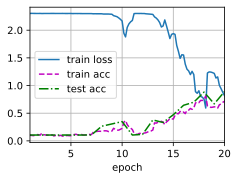

In [63]:
lr, num_epochs = 0.05, 20
d2l.train_ch6(net, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())